Benny Cohen

7/9/2020

Data Science Project 2

Link to summary video: https://screencast-o-matic.com/watch/cYiqh0ElqL

### Introduction

In this notebook, we will explore a dataset about online retailers. The dataset contains various information about the users who visit the websites. We would like to use this information to predict whether a user would be profitable and make a conversion.

To do this, we will use clustering to create our target variable, 'Revenue'. This will be a binary variable, 1 for making a profit, and 1 without. We will then compare this variable with the known labels to evaluate our clustering algorithm.

After creating each clustering, we will also do some eda to see if we can tell the difference between our clusters.

Afterwards, we will create an SVM model to predict the Revenue column. We will evaluate this model using the known labels and the labels we got through clustering. 

### Pre-Clustering Exploratory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
username = 'cohenb51'
path = 'Katz_School/develop/DAV6150/project2/Project2_Data.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/{username}/{path}')

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


We could group our columns into various types. 
#### Web site visits per category:
1. 	Administrative - how many times did the user visit administrative websites.
2. Informational - how many times did the user visit informational websites.
3. Product - how many times did the user visit product websites.

These all should be integer data. 

#### Web site duration per category:
1. Administrative_Duration
2. Informational_Duration
3. Product_Duration

These variables give the duration spent on each of the topics.
These are continuous data. 

#### User Metadata
1. OperatingSystems - The operating system the user is using 
2. Browser - The browser the user is using. 
3. Region	- The region the traffic is coming from.
4. TrafficType - The type of internet traffic.
5. VisitorType - Labels type of user (returning or non returning)
6. Weekend - boolean for value set to true if it is a weekday.

These are all categorical variables. 


#### Other
Bounce Rate - percent of users who enter the site and then leave without triggering any other requests. This variable is actually on a different grain as it is on the site level.This is a decimal.

Exit Rate - for all pageviews to the page, the percentage that were the last in the session. In other words, this value is the ratio of users who exit the domain after viewing this page. This naturally is strongly correlated to the Bounce Rate.

Page value is calculated as such https://support.google.com/analytics/answer/2695658?hl=en. It gives an idea of how much the website contributed to the revenue. This is a decimal.

Special Day - How close the day is to a 'special day' (ex - holidays). This is a decimal.



If we were to create a model for revenue, I would think that all of these variables would be important, although some may be more important than others. For example, users who spend a lot of time on 'Product' pages, may be more likely to buy something. Likewise the type of internet traffic is important since for example, users who are redirected from a social media page may be less likely to make a purchase than users who search for the product. The operating system a person has also can be revealing. For example, a person using an old operating system may be less likely to buy a new product depending on what the product is although this relationship will be weaker. Similarly, people who visit a page for administrative reasons may be less likely to make a purchase although they still might visit the administrative page to check something and then proceed to make a purchase. 

In [5]:
df.shape

(12330, 17)

Our dataset has about 12,000 rows so we don't really need to worry about the dataset being too small

In [6]:
df.isnull().any().any()

False

Our dataset does not contain any nulls.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
dtypes: bool(1), float64(7), int64(7), object(2)
memory usag

The data types all conform to what we would expect based on the description. Administrative, Informational, ProductRelated are all discrete integers representing the number of page visits. Administrative_Duration, Informational_Duration, ProductRelated_Duration , BounceRates,ExitRates, PageValues, SpecialDay are continuous. The rest are categorical.              

Let's look at our distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016B710AC4E0>,
      dtype=object)

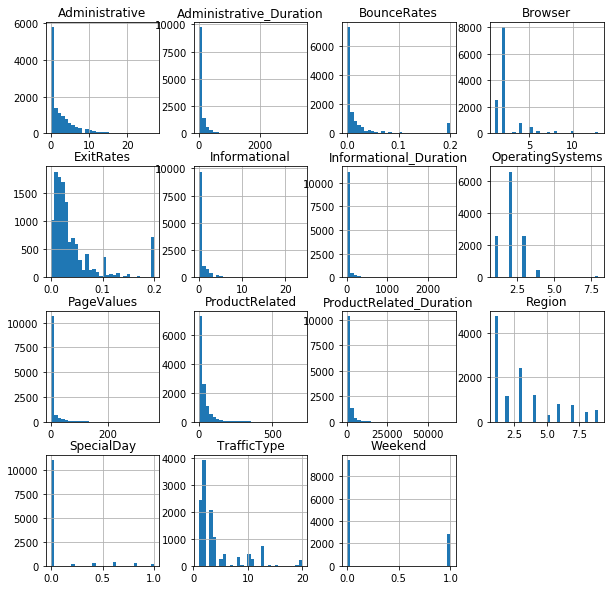

In [8]:
df.hist(figsize = (10,10), bins = 30)

We see that a lot of web site visits per category and web site duration column by time are rightly skewed with some outliers. It is makes sense that our data would be rightly skewed since there would be some people who spend a lot of time on sites for various reasons.Our special day variable is mainly 0 which makes sense as most days are sadly not special. Also our other columns (pageValues, exit rates, and bounce rates) are all rightly skewed.

We also see that most did not  take place on the weekend.

One thing to notice is that our variables are not on the same scale. For example, BounceRates ranges from around 0 to .2 but the page values variable goes past 200. I find it odd that this has such high values so let's look at this a bit more.

In [9]:
high = df[df.PageValues > 100]
len(high)

82

Only 82 values are above 200.

In [10]:
high.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
62,1,24.0,0,0.0,15,496.750000,0.0,0.006250,115.486250,0.0,May,2,2,3,2,Returning_Visitor,False
79,0,0.0,0,0.0,8,642.000000,0.0,0.028571,109.121156,0.0,Dec,2,2,3,2,New_Visitor,False
295,0,0.0,0,0.0,13,1314.083333,0.0,0.008333,103.061083,0.0,Dec,8,13,9,20,Other,False
332,2,49.4,0,0.0,45,1526.141190,0.0,0.004444,117.616593,0.0,Sep,2,2,3,2,Returning_Visitor,True
1201,0,0.0,0,0.0,7,284.500000,0.0,0.028571,128.468694,0.0,Dec,2,2,4,10,Returning_Visitor,False


In [11]:
print(df.mean())
print(high.mean())

Administrative                2.315166
Administrative_Duration      80.818611
Informational                 0.503569
Informational_Duration       34.472398
ProductRelated               31.731468
ProductRelated_Duration    1194.746220
BounceRates                   0.022191
ExitRates                     0.043073
PageValues                    5.889258
SpecialDay                    0.061427
OperatingSystems              2.124006
Browser                       2.357097
Region                        3.147364
TrafficType                   4.069586
Weekend                       0.232603
dtype: float64
Administrative                2.292683
Administrative_Duration     114.543033
Informational                 0.487805
Informational_Duration       26.769106
ProductRelated               37.207317
ProductRelated_Duration    1272.132762
BounceRates                   0.001697
ExitRates                     0.011966
PageValues                  151.042675
SpecialDay                    0.000000
OperatingS

I don't see anything particular unusual about these rows. Note the mean value for the categorical values aren't meaningful.

Let's look at the distribution of our traffic types.

In [12]:
df.TrafficType.value_counts().sort_values()

17       1
12       1
16       3
18      10
14      13
19      17
15      38
7       40
9       42
20     198
11     247
5      260
8      343
6      444
10     450
13     738
4     1069
3     2052
1     2451
2     3913
Name: TrafficType, dtype: int64

Most traffic types are 1 or 2.

In [13]:
df.Month.value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

May has the highest. A couple of months aren't here. This makes it seem like data just wasn't collected all year round at the same schedule.

In [14]:
df.OperatingSystems.value_counts()

2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

And most operating systems are 2. 

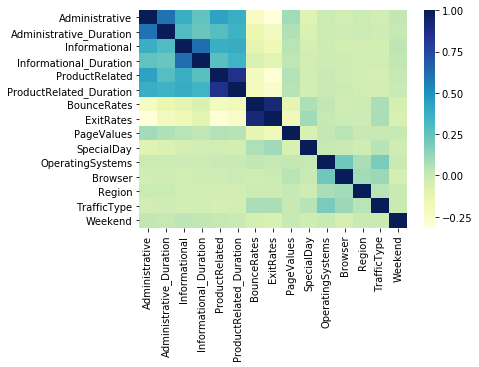

In [15]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

The strongest correlations are between bounce rates, and exit rates. This makes sense as sites which users bounce also would increase the exit rate. 
We see also that there are high correlations between the columns that keep track of page visited and page duration times. There is also a small correlation between operating system, and browser. The rest of the correlations are pretty week.

### Pre-Clustering Data Preparation

We need to...
1. One hot encode our categorical variables.
2. convert our numerical variables to be on the same scale.

In [16]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

In [17]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


In [18]:
cleaned = df.copy()

In [19]:
categorical= cleaned[['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']]

In [20]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 7 columns):
Month               12330 non-null object
OperatingSystems    12330 non-null int64
Browser             12330 non-null int64
Region              12330 non-null int64
TrafficType         12330 non-null int64
VisitorType         12330 non-null object
Weekend             12330 non-null bool
dtypes: bool(1), int64(4), object(2)
memory usage: 590.1+ KB


In [21]:
for i in categorical.columns:
    categorical[i] = categorical[i].astype(object)

C:\Users\b-coh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
encoded = pd.get_dummies(categorical)

In [23]:
encoded.columns

Index(['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18',

This gave us the columns but we have an extra column in each group. (ex - we have weekend_false and weekend_true which is duplicate info since we really only need 1 of those columns.)

In [24]:
encoded = encoded.drop(['Month_Aug','OperatingSystems_8', 'Browser_13', 'Region_9', 'TrafficType_20', 'VisitorType_Other', 'Weekend_True'], axis = 1)

Now we need to scale our numeric columns.

We will use Min Max scaling so as to perserve the outliers.

In [25]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

In [26]:
from sklearn import preprocessing

numCols = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
numDf = df[numCols]
mm_scaler = preprocessing.MinMaxScaler()
numDf[numCols]= mm_scaler.fit_transform(numDf[numCols])

C:\Users\b-coh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\b-coh\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now  we need to merge our data.

In [27]:
len(numDf)

12330

In [28]:
cleaned = numDf.merge(encoded, how = 'inner', left_index=True, right_index=True)

In [29]:
len(cleaned)

12330

In [30]:
cleaned.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Region_1', 'Region_2', 'Region_3',
       'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11

Now in terms of collinearity, since we are using a distance based metric, keeping redundant features will emphasize these features importance.I will drop exit rates therefore since it's almost identical to Page Values. I think that we should keep for now at least the duration columns even though they are correlated with the topic columns because it isn't a 1:1 relationship and each variable is adding information.

In [31]:
cleaned = cleaned.drop(['ExitRates'], axis = 1)

In [32]:
cleaned.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Region_8', 'TrafficType_1', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10',
       'TrafficType_11', 'TrafficTy

We shouldn't per say use all the columns but we should do is empirically look at our clusters after creating the model and see if any variable has more weight than it should.

For example, region may indicate if a user is would make a purchase since people may buy more things in certain regions. If after making our clusters we see that our clusters are heavily influenced by this variable may we reconsider including it unless we know for a fact that this impacts revenue. 

This isn't applicable to the first steps in the assignment where we are just seeing how many clusters make sense to split the customers into. This is more important when we specifically are trying to group customers into groups o created revenue or didn't.

Another point is that we are going to pretend that we don't have the actual data labels when we create our clusters since I don't want to overfit. 

We should check that we haven't changed any of the distributions for the columns we used min max scaling for.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016B76386588>,
      dtype=object)

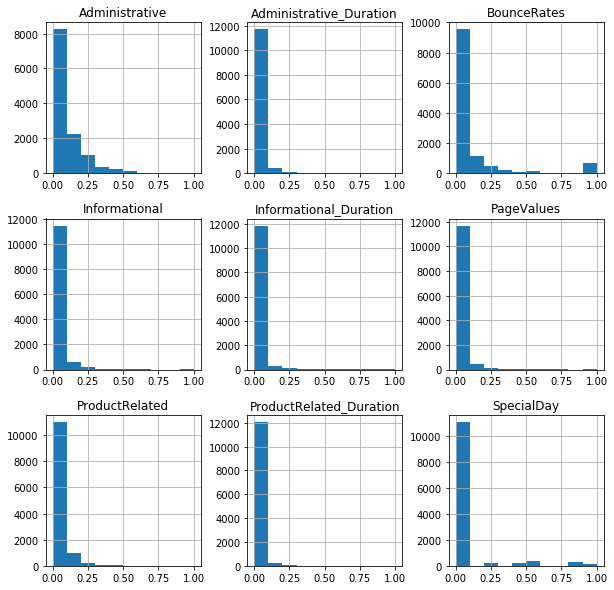

In [37]:
#numCols.remove('ExitRates') 
cleaned[numCols].hist(figsize = (10,10))

We see that all of our distributions are still rightly skewed just now they all are on a scale from 0 to 1.

## ClusterModeling

### Constructing a hierarchical model

In this section, we will be constructing a hierarchical model. At this point, I am not sure what a good number of clusters is - Customers can all into multiple clusters depending on the number of features. Here we don't have that many features so I would expect K to be small.

In [38]:
import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

from sklearn.cluster import AgglomerativeClustering


We will use single linkage as that is most effective. This means we will build our clusters bottom up and combine them based on the minimum distance between the 2 neighbors.

In [39]:
df.shape

(12330, 17)

In [45]:
z = linkage(cleaned,"single")


Our dataset contains 12,000 + rows so obviously we can't show the complete dendogram. We will show the first 40 levels.

This dendogram shows the top 40 levels. The higher the levels the bars meet on the curve, the more disamilar the clusters are. Likewise, the lower the bars meet, the less distance there is between each centroid.

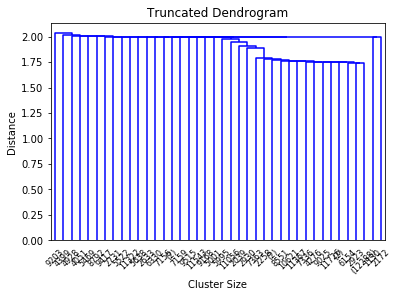

In [46]:
dendrogram(z,truncate_mode= "lastp", p =40)
plt.figsize = (15,15)
plt.title("Truncated Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

We look towards the top of the graph and see how long the lines are. 

I think based on this graph I would include 3 clusters. We see we have 2 very long vertical lines on the right side of the graph indicating that those sub clusters are very different than the cluster on the left which has closer lines. 

The problem though is that none of these lines are meeting lower in the graph. This is telling us that these points are really equally similar to its neighbors. 

In [52]:
from sklearn.cluster import (
    AgglomerativeClustering,
)
ag = AgglomerativeClustering(
    n_clusters=3,
    affinity="euclidean",
    linkage="single",
)
clusters = ag.fit(cleaned) 

In [59]:
df['ag'] = clusters.labels_


In [61]:
df.groupby('ag').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
ag,,,,,,,,,,,,,,,
0,2.314082,80.616159,0.501703,34.311667,31.679267,1191.438162,0.022189,0.043068,5.890151,0.061437,2.124108,2.356668,3.147631,4.068868,0.232479
1,17.000000,2629.253968,24.000000,2050.433333,705.000000,43171.233380,0.004851,0.015431,0.763829,0.000000,2.000000,2.000000,1.000000,14.000000,1.000000
2,1.000000,28.200000,0.000000,0.000000,2.000000,0.000000,0.066667,0.133333,0.000000,0.000000,1.000000,8.000000,2.000000,3.000000,1.000000


Cluster 1 seems to have a very high administrative, and product level duration. Cluster 1 seems to visit very high page values while cluster 3 has page values close to 0 and used browser 8 almost exclusively.

In [62]:
l1 = df[df['ag'] == 0]
l2 = df[df['ag']== 1]
l3 = df[df['ag']== 2]

In [67]:
l3.Browser.value_counts()

8    1
Name: Browser, dtype: int64

In [68]:
l2.Browser.value_counts()

2    1
Name: Browser, dtype: int64

Actually, it seems like this clustering was isn't working because it is grouping everything into cluster 0 except for 1 row for each of the other categories which it deems most unlike the other categories. 

Let's see what happens if we increase k

In [69]:
from sklearn.cluster import (
    AgglomerativeClustering,
)
ag = AgglomerativeClustering(
    n_clusters=20,
    affinity="euclidean",
    linkage="single",
)
clusters = ag.fit(cleaned) 

In [70]:
df['ag2'] = clusters.labels_

In [79]:
l1 = df[df['ag2'] == 0]
l2 = df[df['ag2']== 1]
l3 = df[df['ag2']== 2]
l3 = df[df['ag2']== 3]

In [80]:
len(l1)

12310

In [81]:
len(l2)

2

In [82]:
len(l3)

1

In this case we used 20 clusters and we are noticing the same thing. This algorithm wants to group all the entries into the same cluster. 

Going back to the dendogram, we can understand why this is happening. All the lines are meeting at the top of the graph. That means that each point is about equally distant from the point next to it. When we try to cluster the points then into 2 groups, it sees all the points next to it as equal. 

Now let's see what value of k would be best if we use k means.

In [89]:
from sklearn.cluster import KMeans
inertias = []
sizes = range(2,20)
for k in sizes:
    Kmean = KMeans(n_clusters=k)
    Kmean.fit(cleaned)
    inertias.append(Kmean.inertia_)

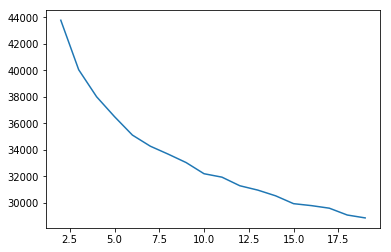

In [90]:
plt.plot(sizes,inertias)

Inertia is a function of the distance of each point to the centroid. Obviously, the lower more centroids then, the better the distance.We therefore look for an elbow in the graph. To me, this graph looks pretty smooth. We therefore can also use silhouette scores. This scores how far each point is within the cluster. 

In [91]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
sizes = range(2,20)
for k in sizes:
    Kmean = KMeans(n_clusters=k)
    Kmean.fit(cleaned)
    silhouette_scores.append(silhouette_score(cleaned, Kmean.labels_))

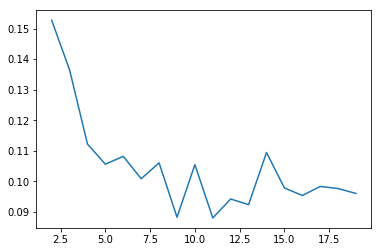

In [92]:
plt.plot(sizes, silhouette_scores)


We see that our our highest silhouette scores are at 2 and 3 but the scores are all very low. This kind of tells us that KMeans might not be the right model here. The close to 0 these scores are, the closer these points are to the edge of the decision boundry. We see that most of the points are close to the edge. 

Let's use 1 more metric, The Dallas Bouldin Index. This scores tells us the similarity between clusters. The close the score is to 0, the better.

In [93]:
from sklearn import metrics
db_scores = []
sizes = range(2,20)
for k in sizes:
    Kmean = KMeans(n_clusters=k)
    Kmean.fit(cleaned)
    db_scores.append(metrics.davies_bouldin_score(cleaned, Kmean.labels_))

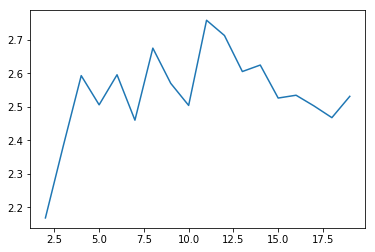

In [94]:
plt.plot(sizes, db_scores)

It seems from this graph the 2 is is the best.

In [95]:
Kmean3 = KMeans(n_clusters=3)
Kmean3.fit(cleaned)
arr =Kmean3.predict(cleaned)

In [96]:
df['Labels3'] = arr

In [97]:
df.groupby('Labels3').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2
Labels3,,,,,,,,,,,,,,,,,
0,2.305455,89.325191,0.536000,31.989632,27.130545,990.624701,0.031943,0.050077,3.670915,0.069600,3.098545,2.106545,3.104000,5.165455,0.289091,0.000000,0.022545
1,2.365891,76.567315,0.503931,37.522881,36.816904,1409.294519,0.016542,0.038835,6.787989,0.063653,2.009072,2.749320,3.212579,3.695343,0.186423,0.000151,0.008618
2,2.211059,82.411656,0.472690,29.971964,24.657114,905.572831,0.025747,0.046029,5.941933,0.048887,1.476736,1.714767,3.042144,3.888065,0.283210,0.000674,0.024275


I created these group by objects to try to see if there is any significant difference between these columns. 
Category 2 seems to spend longer on administrative things, but category 0 seems to spend longer on informational sites. The bounce rate for category 2 seems to be higher and the page value for category 1 seems to be higher.

It seems like category 0 users spend more time looking at products and pages that have high value - making them more likely to make a sale.

In [98]:
df.groupby('Labels3').std()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2
Labels3,,,,,,,,,,,,,,,,,
0,3.348304,178.923684,1.320562,122.099782,36.835630,1388.567256,0.054324,0.053545,12.516683,0.215242,0.462605,0.691312,2.312307,4.667782,0.453423,0.000000,0.577435
1,3.385386,177.979641,1.282753,152.793505,50.733833,2261.353840,0.042091,0.043822,19.893796,0.199668,0.201857,1.648830,2.439379,3.702311,0.389477,0.012296,0.336433
2,3.147947,171.769601,1.191494,128.204875,33.151328,1345.270306,0.054008,0.052769,19.984256,0.180080,1.354512,2.223035,2.394043,3.890874,0.450633,0.036724,0.520167


The variance for all these columns is high so this might not mean much though.

In [188]:
l1 = df[df['Labels3'] == 0]
l2 = df[df['Labels3']== 1]
l3 = df[df['Labels3']== 2]

In [190]:
l1.Browser.value_counts()

2     2611
3      104
6       12
7        9
5        6
12       6
13       1
9        1
Name: Browser, dtype: int64

In [191]:
l2.Browser.value_counts()

2     5071
4      732
5      432
10     160
6      155
7       39
1       13
13       5
12       4
11       2
3        1
Name: Browser, dtype: int64

In [192]:
l3.Browser.value_counts()

1     2449
2      279
8      135
13      55
5       29
6        7
11       4
4        4
10       3
7        1
Name: Browser, dtype: int64

In [ ]:
It seems like the 3rd grouping has more people using browser type 1. 

In [194]:
l1.Month.value_counts()

May     760
Nov     702
Mar     405
Dec     370
Jul     111
Sep     110
Oct     103
Aug      95
June     64
Feb      30
Name: Month, dtype: int64

In [195]:
l2.Month.value_counts()

May     1898
Nov     1538
Mar     1071
Dec      876
Oct      285
Sep      248
Aug      234
Jul      221
June     160
Feb       83
Name: Month, dtype: int64

In [196]:
l3.Month.value_counts()

Nov     758
May     706
Dec     481
Mar     431
Oct     161
Aug     104
Jul     100
Sep      90
Feb      71
June     64
Name: Month, dtype: int64

All of these look around the same.

The differences between type 2 and type 3 are so slight, I don't really think it makes that much sense to cluster into 3 groups.

Let's see if we notice anything significant when we cluster into 2 groups.

In [101]:
Kmean2 = KMeans(n_clusters=2, random_state = 1234)
Kmean2.fit(cleaned)
arr =Kmean2.predict(cleaned)

In [102]:
df['Labels2'] = arr

In [103]:
df.groupby('Labels2').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2,Labels3
Labels2,,,,,,,,,,,,,,,,,,
0,2.141982,79.731001,0.467279,27.919034,24.061232,884.472666,0.026493,0.047129,5.484263,0.051971,1.358974,1.399923,2.915040,3.574818,0.287409,0.000765,0.011098,1.995408
1,2.361737,81.111080,0.513327,36.234664,33.794072,1278.181930,0.021035,0.041982,5.998165,0.063970,2.329731,2.614490,3.209838,4.202635,0.217866,0.000103,0.016672,0.754554


When splitting into 2 groups, it seems like category 1 as a whole is spending more time on sites. Each of the website category types (Administrative_Duration, Informational_Duration, and ProductRelated_Duration) have higher values. They also have a lower Bounce Rate and the value on the sites they are looking on is higher. We can't really see categorical data from this though so let's look at our other variables.

In [104]:
df.groupby('Labels2').OperatingSystems

In [105]:
l1 = df[df['Labels2'] == 0]
l2 = df[df['Labels2']== 1]


In [106]:
l1.OperatingSystems.value_counts()

1    2305
4     279
2      15
7       7
8       6
3       1
Name: OperatingSystems, dtype: int64

In [107]:
l2.OperatingSystems.value_counts()

2    6586
3    2554
1     280
4     199
8      73
6      19
5       6
Name: OperatingSystems, dtype: int64

This is interesting, Operating Systems seems to be playing a large role in our clustering algorithm. We see that there are a lot more rows with an operating system of 2 in those with the label of 1.

I don't think this is really a bad thing... A person with an old operating system or an expensive one may be more or less likely to buy something based on their buying habits. It does seem like this variable is having too much weight so I will recreate the model without this feature.

In [108]:
l1.Region.value_counts()

1    1096
3     547
4     279
2     218
6     158
8     103
7     100
9      74
5      38
Name: Region, dtype: int64

In [109]:
l2.Region.value_counts()

1    3684
3    1856
2     918
4     903
7     661
6     647
9     437
8     331
5     280
Name: Region, dtype: int64

This variable does not seem to have a large weight.

In [110]:
cleaned_2 = cleaned.drop(['OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12'], axis = 1)

In the first part of the assignment we weren't clustering to predict a binary variable for revenue. At this point though, we are clustering to predict revenue and it is bothersome for these columns to be bearing so much weight. Our goal is to label revenue, not operating systems or browsers. These can be useful when we construct our svm model later, but I think at the very least we should look at how our model does when we use other variables.

Now that we dropped these columns though, we should look to see if using k = 2 makes sense.

In [111]:
Kmean2 = KMeans(n_clusters=2, random_state = 1234)
Kmean2.fit(cleaned_2)
arr =Kmean2.predict(cleaned_2)

In [112]:
df['Labels2a'] = arr

In [113]:
df.groupby('Labels2a').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2,Labels3,Labels2
Labels2a,,,,,,,,,,,,,,,,,,,
0,2.342914,81.559765,0.477086,32.694646,30.421457,1143.235462,0.022256,0.043038,5.881098,0.061060,2.144768,2.430728,4.506887,4.111921,0.237219,0.000265,0.021854,1.006225,0.799073
1,2.271339,79.647958,0.545397,37.280354,33.800628,1276.107354,0.022090,0.043127,5.902146,0.062008,2.091213,2.240795,1.000000,4.002720,0.225314,0.000209,0.005439,1.035356,0.770711


In [114]:
l1 = df[df['Labels2a'] == 0]
l2 = df[df['Labels2a']== 1]

In [115]:
l1.Region.value_counts()

3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: Region, dtype: int64

In [116]:
l2.Region.value_counts()

1    4780
Name: Region, dtype: int64

This model seems to be creating 2 clusters by just saying if a user is in region 1 then put him in cluster 1 else put him in cluster 0. 

This is not what we want. This isn't an issue of scaling because the region variable is a dummy variable.

In [117]:
cleaned_2.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Region_1', 'Region_2', 'Region_3',
       'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor',
       'Weekend_False'],
      dtype='object')

In [118]:
cleaned_3 = cleaned_2.drop(['Region_1', 'Region_2', 'Region_3','Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8'], axis = 1)

In [119]:
Kmean2 = KMeans(n_clusters=2, random_state = 1234)
Kmean2.fit(cleaned_3)
arr =Kmean2.predict(cleaned_3)

In [120]:
df['Labels2b'] = arr

In [121]:
df.groupby('Labels2b').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2,Labels3,Labels2,Labels2a
Labels2b,,,,,,,,,,,,,,,,,,,,
0,1.988148,66.526041,0.401016,25.999741,29.996874,1121.868713,0.030736,0.053488,4.162322,0.078771,2.153686,2.368195,3.124121,4.806981,0.216984,0.00013,0.014978,0.970305,0.797864,0.384084
1,2.854901,104.408110,0.672829,48.456289,34.594368,1315.028571,0.008089,0.025884,8.739519,0.032803,2.075021,2.338779,3.185727,2.852537,0.258383,0.00043,0.016337,1.095443,0.771926,0.393594


This cluster seems to be by a blend of more than 1 column. The differences in the times between product 1 and product 2 are much more pronounced.

I think that we should take our 3rd clusering. The first model was okay but not great; we saw that operating system, did have a big difference between the 2 labels but we also saw some small but consistent differences when we looked at the numeric data. The 3rd clustering clustered more by duration which we would think would be more profitable.

In [122]:
df.groupby('Labels2').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,ag,ag2,Labels3,Labels2a,Labels2b
Labels2,,,,,,,,,,,,,,,,,,,,
0,2.141982,79.731001,0.467279,27.919034,24.061232,884.472666,0.026493,0.047129,5.484263,0.051971,1.358974,1.399923,2.915040,3.574818,0.287409,0.000765,0.011098,1.995408,0.419441,0.406047
1,2.361737,81.111080,0.513327,36.234664,33.794072,1278.181930,0.021035,0.041982,5.998165,0.063970,2.329731,2.614490,3.209838,4.202635,0.217866,0.000103,0.016672,0.754554,0.379129,0.369559


As mentioned earlier, the second row has people who are online more often on Special days, are on sites with higher page values, and spend more time on the sites. We might therefore think they are more likely to be profitable.

### Clustering Output vs. Actual Labels

Let's see how good our predictions are by comparing them to the actual data labels. We have to assume that our indexes will match up. 

In [123]:
username = 'cohenb51'
path = 'Katz_School/develop/DAV6150/project2/Project2_Data_Labels.csv'
labels = pd.read_csv(f'https://raw.githubusercontent.com/{username}/{path}')

In [124]:
from sklearn import metrics


Now, I think that we should decide upfront that we are going to choose the 3rd model. If we don't do this we might wind up overfitting the data. Although we are using a clustering algorithm, we still do have the data labels available to us so we can use them to evaluate our clusters. I'll look at all the metrics though to see if our choice of the 3rd clustering was good.

In [125]:
print(f"1st set of columns accuracy score : {metrics.accuracy_score(labels, df.Labels2)}")
print(f"2nd set of columns accuracy score : {metrics.accuracy_score(labels, df.Labels2a)}")
print(f"3rd set of columns accuracy score : {metrics.accuracy_score(labels, df.Labels2b)}")

1st set of columns accuracy score : 0.3037307380373074
2nd set of columns accuracy score : 0.5826439578264396
3rd set of columns accuracy score : 0.6355231143552311


Our choice of columns to cluster had the best accuracy. Note though - the first column accuracy could be the highest if we flip our 1 to be a 0 and a 0 to be a 1. Let's create a new column with this inversion so we can see the other scores with this.

In [126]:
df['labels2Invert'] = 1 - df.Labels2 

This is not consistent though with what we said above since we said a 1 makes it more likely that the person made  purchase since they spend more time on the sites.

In [127]:
print(f"1st set of columns accuracy score Inverted : {metrics.accuracy_score(labels, df.labels2Invert)}")

1st set of columns accuracy score Inverted : 0.6962692619626926


In [128]:
print(f"1st set of columns recall score : {metrics.recall_score(labels, df.Labels2)}")
print(f"1rd set of columns recall score Inverted : {metrics.recall_score(labels, df.labels2Invert)}")
print(f"2nd set of columns recall score : {metrics.recall_score(labels, df.Labels2a)}")
print(f"3rd set of columns recall score : {metrics.recall_score(labels, df.Labels2b)}")

1st set of columns recall score : 0.7966457023060797
1rd set of columns recall score Inverted : 0.20335429769392033
2nd set of columns recall score : 0.40408805031446543
3rd set of columns recall score : 0.5414046121593291


The first model had the best recall. Our chosen model had the second best recall. Again note the flip between the first set of cluster

In [129]:
print(f"1st set of columns precision score : {metrics.precision_score(labels, df.Labels2)}")
print(f"1rd set of columns precision score Inverted : {metrics.precision_score(labels, df.labels2Invert)}")
print(f"2nd set of columns precision score : {metrics.precision_score(labels, df.Labels2a)}")
print(f"3rd set of columns precision score : {metrics.precision_score(labels, df.Labels2b)}")

1st set of columns precision score : 0.15642688072450345
1rd set of columns precision score Inverted : 0.1484883275928052
2nd set of columns precision score : 0.16129707112970712
3rd set of columns precision score : 0.22205503009458297


All of these models have very bad precision. This means of the classes that we predicted truly had a revenue, only 15-22 percent actually gave revenue.

I think this could be a problem depending on what the model gets used for. If we invest a lot of money towards these positive predictions, this could be a problem

In [130]:
print(f"1st set of columns f1 score : {metrics.f1_score(labels, df.Labels2)}")
print(f"1rd set of columns f1 score Inverted : {metrics.f1_score(labels, df.labels2Invert)}")
print(f"2nd set of columns f1 score : {metrics.f1_score(labels, df.Labels2a)}")
print(f"3rd set of columns f1 score : {metrics.f1_score(labels, df.Labels2b)}")

1st set of columns f1 score : 0.26150537634408605
1rd set of columns f1 score Inverted : 0.17164344171643442
2nd set of columns f1 score : 0.2305622009569378
3rd set of columns f1 score : 0.3149390243902439


Overall our chosen 3rd clustering had the best f1, accuracy score, and recall score. Also, to me the columns we chose make clusters that more intuitively explain predicting revenue. We see that the columns clustered as 1 spent more time on websites and the websites they looked at has a higher page value on average. The first model could in theory have a higher accuracy score if we flip the sign but this was not consistent with our eda work. 

Now we have no reason really to do this but per the assignment we are supposed to create a new column Revenue_V with the actual labels and Revenue for our clusters.

In [170]:
df['Revenue'] = df.Labels2b
df['V_Revenue'] = labels

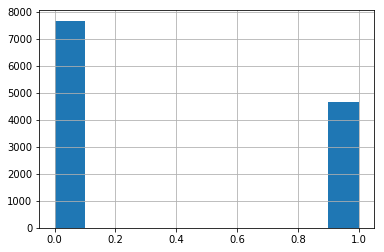

In [179]:
df['Revenue'].hist()

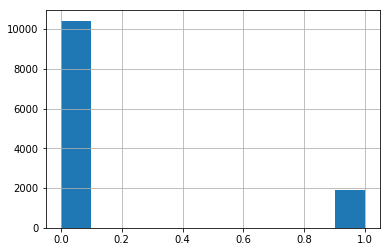

In [180]:
df['V_Revenue'].hist()

In [ ]:
The actual labels denied a bit more people than we did. 

### SVM Models

Now we will create a model to predict Revenue. 

We already did all the cleaning steps. Our clustering was using a distance metric and svm also uses a distance metric.

In [132]:
cleaned.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Region_8', 'TrafficType_1', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10',
       'TrafficType_11', 'TrafficTy

The question is what columns we should be including? I think we should start by creating a model with the same columns we used to construct our clustering. I would expect this to have a really high score just since these are the columns we made our model with.

First let's split into train and test set.

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = cleaned 
y = df.Revenue
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

SVM involves finding a decision boundary that maximizes the distance between the support vectors.

SVM has a few hyperparameters.

C - this is the penalty term we use to avoid overfitting. A large c will try to predict the most number of points possible. A low c will allow for more misclassifications (higher bias) but have lower variance.
Gamma - This is a parameter for the kernel function. This is how we transform our vector into a higher dimension. The higher the gamma, the more curvature we use. In other words, a low gamma would behave similar to a linear model. 
We could use grid search to find the best values for c and Gamma. 

RBF kernels are a popular choice so we will use that. I will use f1 as what to optimize for since our data is skewed as we saw in our eda. 

In [134]:
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001] }

In [ ]:
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(kernel = 'rbf'),param_grid, cv = 5, scoring = 'f1')
res = grid.fit(X_train[cleaned_3.columns],y_train)

In [ ]:
res.best_params_


Our best parameters are with a c of 100 and a gamma of 1. (this takes some time to run so I didn't rerun it)

In [149]:
svc = SVC(C = 100, kernel = 'rbf', gamma = 1)
svc.fit(X_train[cleaned_3.columns],y_train)

SVC(C=100, gamma=1)

In [150]:
preds = svc.predict(X_train[cleaned_3.columns])

In [151]:
print(f"The accuracy score is {metrics.accuracy_score(preds,y_train)}")
print(f"The recall score is {metrics.recall_score(preds,y_train)}")
print(f"The precision score is {metrics.precision_score(preds,y_train)}")

The accuracy score is 1.0
The recall score is 1.0
The precision score is 1.0


In [152]:
metrics.confusion_matrix(preds, y_train)

array([[5757,    0],
       [   0, 3490]], dtype=int64)

Our stats seem to show we have a near perfect model...

This is a bit concerning but we saw with our grid search and 5 folds that our f1 score was above .99. 

Again though, since we are making a model based off of distance this isn't overly surprising that if we use the same columns we would have a really high accuracy.

#### Model 2

Let's create a second model which incorporates more variables...
We are going to do this to see if this can predict Revenue_V more accuratly. There is no real point in trying to find a model that can predict Revenue better than our first model but we saw that the clustering for revenue didn't have the greatest accuracy/f1scores.

In [153]:
cleaned.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Region_8', 'TrafficType_1', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10',
       'TrafficType_11', 'TrafficTy

In [158]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(kernel = 'rbf'),param_grid, cv = 5, scoring = 'f1')
res = grid.fit(X_train,y_train)

In [ ]:
res.best_params_


In [199]:
svc = SVC(C = 100, kernel = 'rbf', gamma = .01)
svc.fit(X_train,y_train)

SVC(C=100, gamma=0.01)

In [200]:
preds = svc.predict(X_train)

In [201]:
print(f"The accuracy score is {metrics.accuracy_score(preds,y_train)}")
print(f"The recall score is {metrics.recall_score(preds,y_train)}")
print(f"The precision score is {metrics.precision_score(preds,y_train)}")

The accuracy score is 0.9996755704552828
The recall score is 0.9994270982526496
The precision score is 0.9997134670487106


In [202]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'TrafficType_1', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10',
       'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
       'TrafficType_15', 'TrafficType_16', 'TrafficType_17', 'TrafficType_18',
       'TrafficType_19', 'VisitorType_New_Visitor',
       'VisitorType_Returning_Visitor', 'Weekend_False'],
      dtype='object')

Adding additional columns does not seem to take a way from our model. I don't see any leaky features that would cause this.

### Select Models

Since model 1 has less columns, we should use that as that would make that model faster. Performance wise, our models both performed nearly per

Let's see how this model will do with new data. It is slightly alarming how accurate this model is. Let's use 10 as we have a our algorithm is O(N) and can do a lot of iterations.

In [185]:
from sklearn.model_selection import cross_val_score
clf = SVC(C = 100, kernel = 'rbf', gamma = 1)
scores = cross_val_score(clf, X_train[cleaned_3.columns], y_train, cv=10)
scores

array([1.        , 1.        , 0.99891892, 0.99783784, 0.99891892,
       1.        , 0.99783784, 0.9978355 , 1.        , 1.        ])

In [211]:
clf = SVC(C = 100, kernel = 'rbf', gamma = .01)
scores = cross_val_score(clf, X_train, y_train, cv=10)
scores

array([1.        , 1.        , 0.99891892, 0.99891892, 0.99891892,
       1.        , 1.        , 0.99891775, 1.        , 1.        ])

In [212]:
len(cleaned_3.columns)

40

In [213]:
len(X_train.columns)

67

We see both our models do well on new data from our cross validation. I would use the first model just since it uses less columns. 

### Evaluating test data.

In [160]:
svc = SVC(C = 100, kernel = 'rbf', gamma = 1)
svc.fit(X_train[cleaned_3.columns],y_train)


SVC(C=100, gamma=1)

In [161]:
preds = svc.predict(X_test[cleaned_3.columns])

In [162]:
print(f"The accuracy score is {metrics.accuracy_score(preds,y_test)}")
print(f"The recall score is {metrics.recall_score(preds,y_test)}")
print(f"The precision score is {metrics.precision_score(preds,y_test)}")

The accuracy score is 0.9996756406097956
The recall score is 1.0
The precision score is 0.9991394148020654


Our scores are lower on the test set, but they are very close to 1. This is nerly a perfect model.

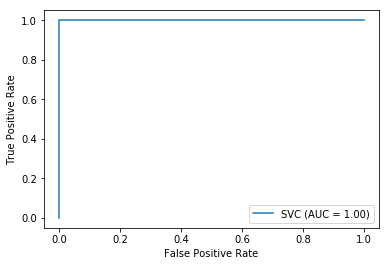

In [163]:
metrics.plot_roc_curve(svc, X_test, y_test)

This is the ideal roc curve which has maximum area and an auc of 1.

### Clustering + SVM Output vs. Actual Labels 

Now let's compare this to our actual data labels... We already know how our clustering model did compared to Revenue_F and our model is virtually ideal but we can repeat this for completeness.

Our cleaned dataset doesn't have the Revenue_F column and we randomly split it...

In [175]:
merged = X_test.merge(df[['V_Revenue']], left_index = True, right_index = True)

In [178]:
print(f"The accuracy score is {metrics.accuracy_score(preds,merged.V_Revenue)}")
print(f"The recall score is {metrics.recall_score(preds,merged.V_Revenue)}")
print(f"The precision score is {metrics.precision_score(preds,merged.V_Revenue)}")
print(f"The f1 score is {metrics.f1_score(preds,merged.V_Revenue)}")

The accuracy score is 0.653584171261758
The recall score is 0.2463393626184324
The precision score is 0.5970772442588727
The f1 score is 0.3487804878048781


The numbers for our scores are basically the same as what we saw above with the 3rd model. They differ slightly but that's only because we are evaluating on less points. 

In [ ]:
By transitivity though, they should be similar since our model accuratly predicts Revenue. 

The accuracy score is above .5 but as we saw, our distribution is skewed towards 0 so this isn't the best metric to use. 

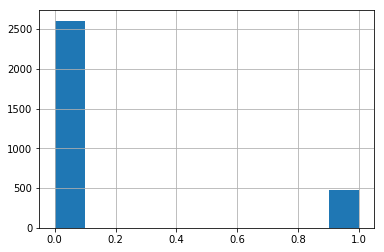

In [181]:
merged.V_Revenue.hist()

The precision score tells us that when we identify a customer as one who made a purchase we are right 60 percent of the time. The low recall score is slightly bothersome because it means that we are missing our on customers who might potentially make a purchase. I think this model would need to be improved significantly by incorporating more features before using it. 

### Conclusions.

1. We were able to cluster our customer dataset into different groups. We saw that when we tried using k with a value of 3 that the clusters were similar so we chose that k = 2 was the best choice. We also saw that all our silhouette scores from k means were low, for almost all ks, implying that our points weren't so close to our centroids and our data may not be distributed in the right way to use kmeans. 

2. When trying to cluster our data into columns to predict Revenue, it was hard to guide the model to weigh the features correctly. The clustering algorithm was clustering into groups but it was hard to pin the groups to specifically cluster based on what we think would predict revenue. 

3. Our svm model was nearly perfect when training on our clusters, but our clusters itself had a very low recall when we compared to the actual data labels, V_Revenue.